# Lung inflammation v2 - ResNet34

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet34 to characterize inflammatory lung diseases from sections of lung tissue.<br><br>

**Publication benchmark:**<br>
Model: Inception V3, pretrained on ImageNet<br>
Accuracy: 0.80 (80%).<br><br>


<font color='blue'>**Notebook results:**<br>
Model: ResNet34, pretrained on ImageNet<br>
Data setup: training and validation data were used as in the provided dataset<br>
Accuracy: 0.82 (82%).<br><br>
    
**Summary:**<br>In this notebook it could be shown that state-of-the-art results published August 23 2018 could be slightly improved with a smaller model in a few minutes of training.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

In [4]:
# set batchsize and image size for network
bs = 32
size = 224

In [69]:
# different transformations (the increase of the max_rotate parameter is crucial to improve the performance)
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0, max_warp=0.2) #1
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #2
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #3

In [70]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_inflammation', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [71]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [72]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '2', '3', 'ignore', '1'], 5, 3974, 726)

## Data exploration

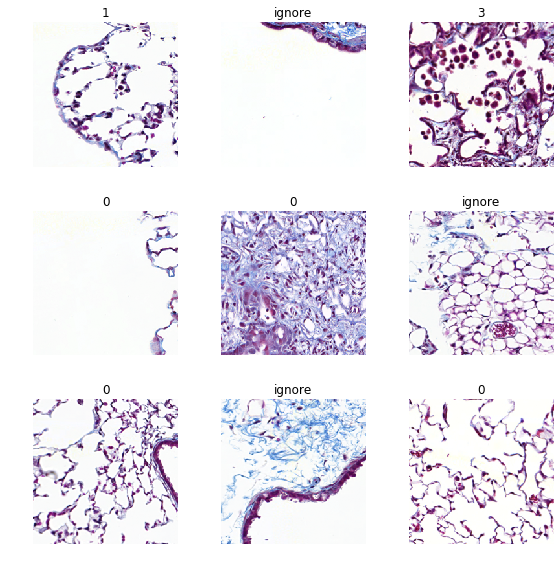

In [9]:
# show a batch
data.show_batch(rows=3, figsize=(8,8))

"For the inflammation model ~3500 images were manually labelled by moving them into folders 0, 1, 2, 3, and ignore. The folder names correspond to the degree of inflammation, defined by the number of inflammatory cells in a field of view. Class 0 corresponds to 0–5 inflammatory cells, class 1 to 6–10, class 2 to 11–20 and class 3 to >21 inflammatory cells."

## Setup model

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [73]:
!gpustat

psbtmxtmo  Thu Nov  1 06:07:23 2018
[0] Quadro P4000     | 52'C,   0 % |  3049 /  8119 MB | paperspace(3039M)


In [74]:
# set dropout
ps = 0.5 # default 0.5

In [75]:
learn = create_cnn(data, models.resnet34, metrics=accuracy, ps=ps)

In [76]:
!gpustat

psbtmxtmo  Thu Nov  1 06:07:25 2018
[0] Quadro P4000     | 51'C,   5 % |  3049 /  8119 MB | paperspace(3039M)


## Training

### Stage 1 - Training of new head

In stage 1 only the new head of the network is trained and rest is frozen.

In [77]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


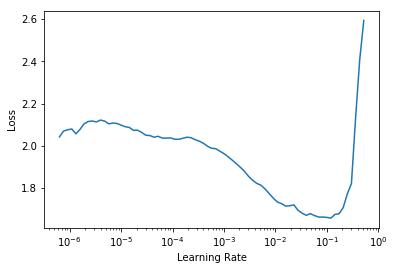

In [78]:
learn.recorder.plot()

In [79]:
lr = 5e-3

In [80]:
learn.fit_one_cycle(12, max_lr=lr)

Total time: 04:59
epoch  train_loss  valid_loss  accuracy
1      1.113853    0.806195    0.695592  (00:23)
2      0.920623    0.680211    0.747934  (00:24)
3      0.791692    0.784804    0.688705  (00:25)
4      0.773110    0.682950    0.720386  (00:24)
5      0.722028    0.635494    0.727273  (00:25)
6      0.675507    0.579877    0.752066  (00:25)
7      0.651792    0.666858    0.752066  (00:24)
8      0.617585    0.509250    0.793388  (00:25)
9      0.574291    0.498136    0.812672  (00:26)
10     0.568673    0.481214    0.818182  (00:24)
11     0.566743    0.479276    0.814050  (00:24)
12     0.544410    0.478495    0.804408  (00:24)



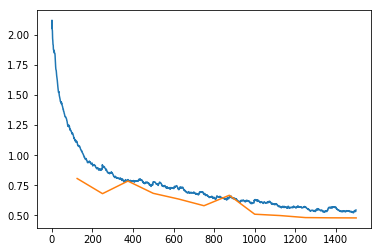

In [81]:
learn.recorder.plot_losses()

In [82]:
learn.save('lung_inf_v2_stage-1_20181101-3')

<font color=blue>**Conclusion stage 1 - Training of new head:**<br>
Training only the the new last layers from the new head (and keeping the rest of the network frozen) enabled the network to achieve a accuracy of approx. 0.81 (81%) after 12 epochs. This is already equal to the published accuracy benchmark!

### Stage 2 - Training of the entire network

In stage 2 the entire network is trained with discriminative learning rates, i.e. lower learning rates for the earyl layers and higher learning rates for the late layers.

In [83]:
learn.load('lung_inf_v2_stage-1_20181101-3')

In [84]:
learn.unfreeze()

In [85]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


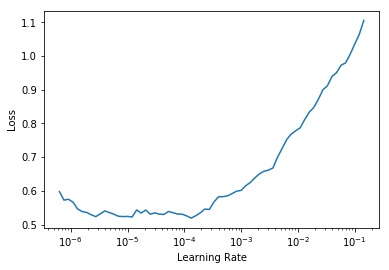

In [64]:
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

Total time: 00:27
epoch  train_loss  valid_loss  accuracy
1      0.537355    0.485425    0.811295  (00:27)



In [87]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, lr/10))

Total time: 04:40
epoch  train_loss  valid_loss  accuracy
1      0.512292    0.481637    0.819559  (00:28)
2      0.529841    0.482626    0.805785  (00:28)
3      0.533183    0.482309    0.820937  (00:28)
4      0.522236    0.479092    0.820937  (00:27)
5      0.513687    0.503302    0.823691  (00:28)
6      0.517527    0.483693    0.816804  (00:27)
7      0.522619    0.495015    0.809917  (00:27)
8      0.481072    0.479794    0.818182  (00:27)
9      0.490501    0.477336    0.819559  (00:27)
10     0.451912    0.493569    0.822314  (00:27)



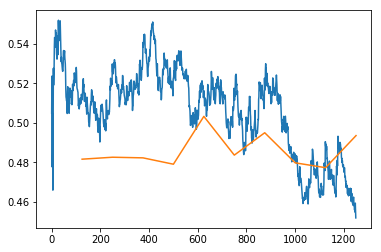

In [88]:
learn.recorder.plot_losses()

In [89]:
learn.save('lung_inf_v2_stage-2_20181101-3')

In [107]:
learn.load('lung_inf_v2_stage-2_20181101-3')

<font color=blue>**Conclusion stage 2 - Training of the entire network:**<br>
The training of the entire network with discriminative learning rates was able to reduce the training loss and increase the accuracy slightly.

## Interpretation

In [108]:
interp = ClassificationInterpretation.from_learner(learn)

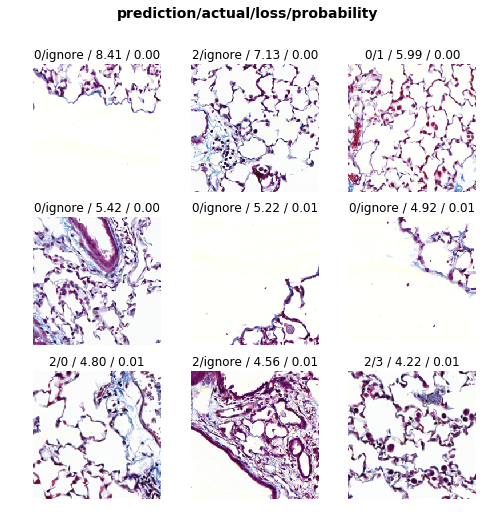

In [112]:
interp.plot_top_losses(9, figsize=(8,8))

In [113]:
interp.confusion_matrix()

array([[250,   2,   0,   6,  18],
       [  1,  44,   7,   1,  22],
       [  1,   8,  58,   2,   1],
       [ 17,   5,   3, 169,   2],
       [ 22,  10,   1,   0,  76]])

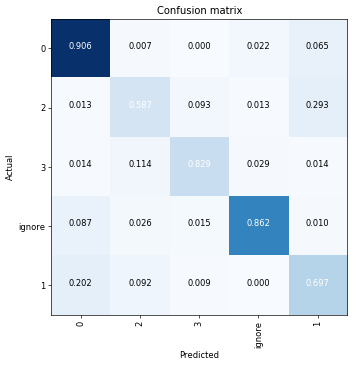

In [124]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)